In [1]:
%load_ext autoreload
%autoreload 2

import evals2

import numpy as np
import scipy
import torch
from torch import nn

SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)

from matplotlib import pyplot as plt
from pandas import DataFrame
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("ticks", {'font.family': 'serif'})
plt.tight_layout()

SEP = '__'

In [2]:
unigrams = set()
bigrams = {}
with open('rep2_data/reddy.txt') as f:
    next(f) # header
    for line in f:
        line = line.split()
        w1, w2 = line[:2]
        sim = float(line[6])
        w1, _ = w1.split('-')
        w2, _ = w2.split('-')
        bigrams[w1, w2] = sim
        unigrams.add(w1)
        unigrams.add(w2)

In [3]:
class Composition(nn.Module):
    def forward(self, x, y):
        return x + y

def measure_comp(context, suffix):
    print('----')
    print("context: "'%s%s' % (context, suffix))
    vecs = {}
    with open('rep2_data/model%d%s.vec' % (context, suffix)) as f:
        for line in f:
            word, *vec = line.split()
            vec = np.asarray([float(v) for v in vec])
            if SEP in word:
                word = tuple(word.split(SEP))
            if word in bigrams or word in unigrams:
                assert word not in vecs
                vecs[word] = vec
    eprim = []
    rprim = []
    ecomp = []
    rcomp = []
    for w1, w2 in bigrams:
        b = (w1, w2)
        if not (w1 in vecs and w2 in vecs and b in vecs):
            continue
        eprim.append(w1)
        rprim.append(vecs[w1])
        eprim.append(w2)
        rprim.append(vecs[w2])
        ecomp.append(b)
        rcomp.append(vecs[b])
    errs = evals2.evaluate(rprim + rcomp, eprim + ecomp, Composition(), evals2.CosDist())
    errs = errs[-len(ecomp):]
    
    scores = [bigrams[e] for e in ecomp]
    data = DataFrame({'err': errs, 'score': scores})
    sns.lmplot(x='err', y='score', data=data)
    plt.xlabel('TRE')
    plt.ylabel('compositionality')
    plt.ylim(0, 5)
    plt.savefig('rep_ctx%d.pdf' % context, format='pdf')
    plt.show()
    print(scipy.stats.spearmanr(errs, scores))
    
    comb = zip(scores, errs, ecomp)
    comb = sorted(comb, key=lambda x: x[1])
    print("compositional:")
    print("%20s %20s %40s" % ("human score", "model err", "words"))
    for c in comb[:5]:
        print("%20.2f %20.2f %40s" % c)
    print()
    print("non-compositional:")
    print("%20s %20s %40s" % ("human score", "model err", "words"))
    for c in comb[-5:]:
        print("%20.2f %20.2f %40s" % c)

----
context: 1
179.83058166503906
20.897193908691406
12.285057067871094
11.350739479064941


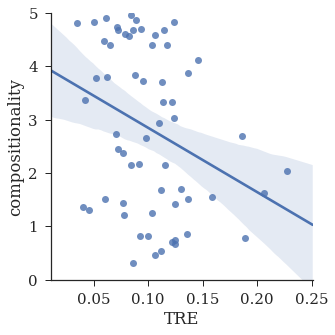

SpearmanrResult(correlation=-0.3119355841789723, pvalue=0.014393280654498644)
compositional:
         human score            model err                                    words
                4.80                 0.03                  ('application', 'form')
                1.37                 0.04                    ('kangaroo', 'court')
                3.37                 0.04                        ('polo', 'shirt')
                1.31                 0.05                        ('snail', 'mail')
                4.82                 0.05                  ('research', 'project')

non-compositional:
         human score            model err                                    words
                1.56                 0.16                          ('cash', 'cow')
                2.69                 0.19                         ('fine', 'line')
                0.78                 0.19                          ('nest', 'egg')
                1.62                 0.21                

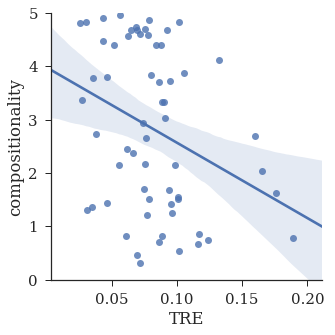

SpearmanrResult(correlation=-0.3145006699423972, pvalue=0.013567998319967852)
compositional:
         human score            model err                                    words
                4.80                 0.03                  ('application', 'form')
                3.37                 0.03                        ('polo', 'shirt')
                4.82                 0.03                  ('research', 'project')
                1.31                 0.03                        ('snail', 'mail')
                1.37                 0.03                    ('kangaroo', 'court')

non-compositional:
         human score            model err                                    words
                4.11                 0.13                        ('role', 'model')
                2.69                 0.16                         ('fine', 'line')
                2.04                 0.17                        ('think', 'tank')
                1.62                 0.18                

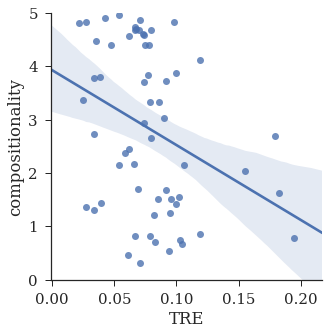

SpearmanrResult(correlation=-0.34938054748835046, pvalue=0.00578273019058657)
compositional:
         human score            model err                                    words
                4.80                 0.02                  ('application', 'form')
                3.37                 0.03                        ('polo', 'shirt')
                4.82                 0.03                  ('research', 'project')
                1.37                 0.03                    ('kangaroo', 'court')
                1.31                 0.03                        ('snail', 'mail')

non-compositional:
         human score            model err                                    words
                0.86                 0.12                          ('rat', 'race')
                2.04                 0.16                        ('think', 'tank')
                2.69                 0.18                         ('fine', 'line')
                1.62                 0.18                

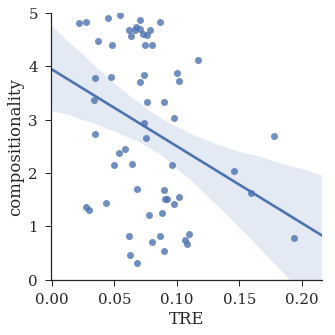

SpearmanrResult(correlation=-0.338882206786498, pvalue=0.0075501473499175065)
compositional:
         human score            model err                                    words
                4.80                 0.02                  ('application', 'form')
                4.82                 0.03                  ('research', 'project')
                1.37                 0.03                    ('kangaroo', 'court')
                1.31                 0.03                        ('snail', 'mail')
                3.37                 0.03                        ('polo', 'shirt')

non-compositional:
         human score            model err                                    words
                4.11                 0.12                        ('role', 'model')
                2.04                 0.15                        ('think', 'tank')
                1.62                 0.16                       ('lip', 'service')
                2.69                 0.18                

In [4]:
for context in [1, 3, 5, 7]:
    for suffix in ['']: #, '_tiny']:
        measure_comp(context, suffix)